In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import glob
from cdo import *
import os
import sys
import datetime 

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5]
cdo = Cdo()

In [3]:
# Import state vector file using geopandas
states_url = 'http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_5m.json'
states_gdf = gpd.read_file(states_url)

In [4]:
# Subset Parameters
# Slice/Subset data down further based on latitutde (-90 -- +90), longitude (0 -- 360)
lat_bnds, lon_bnds = [23, 57], [230, 265]

baseDir='/glade/scratch/currierw/ACCESS1-0/historical/'

In [5]:
# First, we need a regular grid (base) for which we want to transform the `tos` data onto. Let's choose orography
# tos = sea surface temperature [K]
regrdFiles=glob.glob(baseDir+'tos*regrd.nc')
if len(regrdFiles) == 0 :    
    fBase=baseDir+'orog_fx_ACCESS1-0_historical_r0i0p0.nc'
    cdo.griddes("-f "+fBase+" >"+baseDir+"grid.txt")

    fNames=glob.glob(baseDir+'tos*.nc') # get all base sea surface temperature variables
    for files in fNames:
        fTmp=os.path.splitext(files)[0] # remove file extension
        cdo.remapcon("grid.txt ", input=files, output=fTmp+"_regrd.nc", options="-f nc")

In [6]:
#### Choose lat and lon
lat_bnds, lon_bnds  = [23, 57],                      [230, 265]                      # Slicing for Temperature, HUS, Ps etc. (Theta Values)
lat_bndsV,lon_bndsV = [lat_bnds[0]-1,lat_bnds[1]+1], [lon_bnds[0], lon_bnds[1]]      # Slciing for V winds (north-south) add 1 degree buffer to south and north
lat_bndsU,lon_bndsU = [lat_bnds[0],lat_bnds[1]],     [lon_bnds[0]-1, lon_bnds[1]+1]  # Slicing for U winds (east-west) add 1 degree buffer to west and east

#### Data

# Choose U, V, Ta, Hus files from the same time-period
fNameVa  = baseDir+'va_6hrLev_ACCESS1-0_historical_r1i1p1_1980010106-1981010100.nc'
fNameUa  = baseDir+'ua_6hrLev_ACCESS1-0_historical_r1i1p1_1980010106-1981010100.nc'
fNameTa  = baseDir+'ta_6hrLev_ACCESS1-0_historical_r1i1p1_1980010106-1981010100.nc'
fNameHus = baseDir+'hus_6hrLev_ACCESS1-0_historical_r1i1p1_1980010106-1981010100.nc'
fNamePs  = baseDir+'ps_6hrLev_ACCESS1-0_historical_r1i1p1_1980010106-1990010100.nc'
fNameTos  = baseDir+'tos_*_regrd.nc'
fNamePrec = baseDir+'prc_*.nc'

# open the datasets (ds) with xarray
vads  = xr.open_dataset(fNameVa)
uads  = xr.open_dataset(fNameUa) 
tads  = xr.open_dataset(fNameTa) 
husds = xr.open_dataset(fNameHus)
tosds = xr.open_mfdataset(fNameTos,combine='by_coords')
prcds = xr.open_mfdataset(fNamePrec,combine='by_coords')

#### Processing

# Resample Sea Surface Temp Data to 6 Hour data from Daily Mean - does forward fill
tos6Hour  = tosds.resample(time='6H').ffill()
tosOut    = tos6Hour['tos'].sel(time=slice(vads.time[0],vads.time[-1]))  # Time slice based on 6H data file
tosds_sub = tosOut.sel(lat=slice(*lat_bnds), lon=slice(*lon_bnds)) # subset the hus data spatially

# Precipitation is 3D, only time,lat,lon - stored in longer time files in 3 hr data
prcds_sub  = prcds.sel(lat=slice(*lat_bnds), lon=slice(*lon_bnds))  # Subset spatially first
prc6HrSub  = prcds_sub['prc'].resample(time='6H').sum()             # Aggregate from 3H to 6H
prc6HrSub  = prc6HrSub.sel(time=slice(vads.time[0],vads.time[-1]))  # Time slice based on 6H data file

# Surface Air Pressure [Pa] - (time,lat,lon)
psds       = xr.open_dataset(fNamePs)
psds_tsub  = psds.sel(time=slice(vads.time[0],vads.time[-1]))           # Time slice based on 6H data file
psds_sub   = psds_tsub.sel(lat=slice(*lat_bnds), lon=slice(*lon_bnds))  # Subset air pressure data

# Slice/Subset 4D data
vads_sub  = vads.sel(lat=slice(*lat_bndsV), lon=slice(*lon_bndsV))  # subset the Va data spatially
uads_sub  = uads.sel(lat=slice(*lat_bndsU), lon=slice(*lon_bndsU))  # subset the Ua data spatially
tads_sub  = tads.sel(lat=slice(*lat_bnds),  lon=slice(*lon_bnds))  # subset the ta data spatially
husds_sub = husds.sel(lat=slice(*lat_bnds), lon=slice(*lon_bnds)) # subset the hus data spatially

# print("\nSize of 4D Files")
# print("\nSubsetted Air Temperautre Data Size =")
# print(tads_sub['ta'].shape)
# print("\nSubsetted Humidity Data Size =")
# print(husds_sub['hus'].shape)
# print("\nSubsetted V Winds Data Size =")
# print(vads_sub['va'].shape)
# print("\nSubsetted U Winds Data Size =")
# print(uads_sub['ua'].shape)

In [7]:
if tads_sub['lon'][0]-uads_sub['lon'][0] > 0 and tads_sub['lon'][-1]-uads_sub['lon'][-1] < 0 :
    print('U east-west wind longitude data were sliced correctly')
else:
    sys.exit("The longitude data for the U data were not sliced correctly")
        
if tads_sub['lat'][0]-vads_sub['lat'][0] > 0 and tads_sub['lat'][-1]-vads_sub['lat'][-1] < 0 :
    print('V north-south wind latitude data were sliced correctly')
else:
    sys.exit("The longitude data for the U data were not sliced correctly")

U east-west wind longitude data were sliced correctly
V north-south wind latitude data were sliced correctly


In [8]:
# Interpolate data from staggered grid to temperature grid
print("\nInterpolating Data")
uads_subI = uads_sub.interp(lat=tads_sub['lat'], lon=tads_sub['lon'])
vads_subI = vads_sub.interp(lat=tads_sub['lat'], lon=tads_sub['lon'])


Interpolating Data


In [9]:
# Calculate the model level heights [m]
z_t=tads_sub.lev+(tads_sub.b*tads_sub.orog)
print('\nCalculating Model Level Heights')


Calculating Model Level Heights


In [10]:
# Calculate water vapor mixing ratio (w/Qv) [kg/kg] from specific humdiity
print('\n Convert from Specific Humidity to Water Vapor Mixing Ratio')
husds_sub['Qv'] = husds_sub['hus']/(1-husds_sub['hus'])


 Convert from Specific Humidity to Water Vapor Mixing Ratio


In [11]:
# Creating New Dataset
print("\nCreating new dataset\n")

# Create New Datasets that's just the datasets with dimensions and coordinates

######## Terrain Height
ds_orog = xr.Dataset({"HGT":(("lat","lon"),tads_sub.orog)},
                 coords={"lat":tads_sub.lat,"lon":tads_sub.lon})
ds_orog['HGT'].attrs['standard_name'] = 'Terrain Height'
ds_orog['HGT'].attrs['long_name']     = 'Terrain Height'
ds_orog['HGT'].attrs['units']         = 'm'
ds_orog['HGT'].attrs['Processing Note'] = 'Provided from temeprature dataset - orogoraphy variable'

######## 3D Model Level Heights [m]
ds_Z    = xr.Dataset({"Z":(("lev","lat","lon"),z_t)},
                 coords={"lev":tads_sub.lev,"lat":tads_sub.lat,"lon":tads_sub.lon})
ds_Z['Z'].attrs['standard_name'] = '3D model level heights'
ds_Z['Z'].attrs['long_name'] = '3D Model Level Heights'
ds_Z['Z'].attrs['units'] = 'm' 
ds_Z['Z'].attrs['Processing Note'] = 'Calculated using temperature lev coordinates, b values, and orogoraphy varaibles. Z = lev + b * orog' 

######## Surface Air Pressure [Pa]
ds_Ps   = xr.Dataset({"Ps":(("time","lat","lon"),psds_sub.ps)},
                 coords={"time":psds_sub.time,"lat":psds_sub.lat,"lon":psds_sub.lon})
ds_Ps['Ps'].attrs = psds_sub.ps.attrs

######## Sea Surface Temeperature [K]
ds_SST  = xr.Dataset({"SST":(("time","lat","lon"),tosds_sub)},
                 coords={"time":tosds_sub.time,"lat":tosds_sub.lat,"lon":tosds_sub.lon})
ds_SST['SST'].attrs = tosds['tos'].attrs
ds_SST['SST'].attrs['Processing Note'] = 'Daily data forward filled to 6H data' 

######## Precipitation [kg m-2 s-1]
ds_prec = xr.Dataset({"prec":(("time","lat","lon"),prc6HrSub)},
                 coords={"time":tads_sub.time,"lat":tads_sub.lat,"lon":tads_sub.lon})
ds_prec['prec'].attrs['standard_name'] = prcds_sub['prc'].attrs['standard_name']
ds_prec['prec'].attrs['long_name'] = prcds_sub['prc'].attrs['long_name']
ds_prec['prec'].attrs['comment'] = 'at surface. This is a 6-hour mean convective preciptiation'
ds_prec['prec'].attrs['units'] = prcds_sub['prc'].attrs['units']
ds_prec['prec'].attrs['cell_methods'] = prcds_sub['prc'].attrs['cell_methods']
ds_prec['prec'].attrs['cell_measures'] = prcds_sub['prc'].attrs['cell_measures']
ds_prec['prec'].attrs['associated_files'] = prcds_sub['prc'].attrs['associated_files']
ds_prec['prec'].attrs['Processing Note'] = 'Resample from 3H data to 6H data using the sum between time-steps'

######## Air Temperature [K[]]
ds_T = xr.Dataset({"T":(("time","lev","lat","lon"),tads_sub.ta)},
                  coords={"time":tads_sub.time,"lev":tads_sub.lev,"lat":tads_sub.lat,"lon":tads_sub.lon})
ds_T['T'].attrs = tads_sub.ta.attrs

######## Water Vapor Mixing Ratio [kg/kg]
ds_Qv = xr.Dataset({"Qv":(("time","lev","lat","lon"),husds_sub.Qv)},
                   coords={"time":husds_sub.time,"lev":husds_sub.lev,"lat":husds_sub.lat,"lon":husds_sub.lon})
ds_Qv['Qv'].attrs['standard_name'] = 'Water Vapor Mixing Ratio'
ds_Qv['Qv'].attrs['long_name'] = 'Water Vapor Mixing Ratio'
ds_Qv['Qv'].attrs['units'] = 'kg/kg'
ds_Qv['Qv'].attrs['cell measures'] = husds_sub['hus'].attrs['cell_measures']
ds_Qv['Qv'].attrs['history'] = husds_sub['hus'].attrs['history']
ds_Qv['Qv'].attrs['associated_files'] = husds_sub['hus'].attrs['associated_files']
ds_Qv['Qv'].attrs['Processing Note'] = 'Calculated from specific humidity (q) data Qv = q/1-q'

######## North South Wind Speeds [m s-1]
ds_v = xr.Dataset({"V":(("time","lev","lat","lon"),vads_subI.va)},
                  coords={"time":vads_subI.time,"lev":tads_sub.lev,"lat":vads_subI.lat,"lon":vads_subI.lon})
ds_v['V'].attrs = vads_subI.va.attrs
ds_v['V'].attrs['Processing Note'] = 'Interpolated/Regrided from staggered north-south grid - one additional row offset by 1/2 a grid cell in latitude to the temperature grid'

######## East Wind Wind Speeds [m s-1]
ds_u = xr.Dataset({"U":(("time","lev","lat","lon"),uads_subI.ua)},
                  coords={"time":uads_subI.time,"lev":tads_sub.lev,"lat":uads_subI.lat,"lon":uads_subI.lon})
ds_u['U'].attrs = uads_subI.ua.attrs
ds_u['U'].attrs['Processing Note'] = 'Interpolated/Regrided from staggered east-west grid - one additional column offset by 1/2 a grid cell in longitude to the temperature grid'
                     
# Make a new dataset
ds = xr.merge([ds_orog, ds_Z, ds_Ps, ds_SST, ds_prec, ds_T, ds_Qv, ds_v, ds_u])

print("Created new dataset")
now = datetime.datetime.now()
ds.attrs['Condensed/Merged File Created'] = now.strftime("%m/%d/%Y, %H:%M:%S")
ds.attrs = tads.attrs


Creating new dataset

Created new dataset


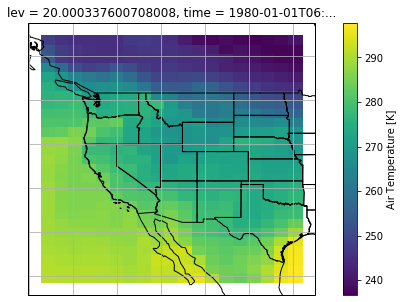

In [12]:
# Temperature
ax = plt.axes(projection=ccrs.PlateCarree())
p = ds['T'][0,0,:,:].plot(x='lon', y='lat',transform=ccrs.PlateCarree(),subplot_kws={'projection': ccrs.PlateCarree()})
ax.coastlines();ax.gridlines();ax.add_geometries(states_gdf.geometry, crs = ccrs.PlateCarree(),facecolor='none', edgecolor='black')

In [13]:
ds

<xarray.Dataset>
Dimensions:  (lat: 27, lev: 38, lon: 19, time: 1464)
Coordinates:
  * lat      (lat) float64 23.75 25.0 26.25 27.5 28.75 ... 52.5 53.75 55.0 56.25
  * lon      (lon) float64 230.6 232.5 234.4 236.2 ... 258.8 260.6 262.5 264.4
  * lev      (lev) float64 20.0 80.0 180.0 ... 2.922e+04 3.291e+04 3.925e+04
  * time     (time) datetime64[ns] 1980-01-01T06:00:00 ... 1981-01-01
Data variables:
    HGT      (lat, lon) float32 0.0 0.0 0.0 ... 281.29388 231.37709 171.20233
    Z        (lev, lat, lon) float64 20.0 20.0 20.0 ... 3.925e+04 3.925e+04
    Ps       (time, lat, lon) float32 101739.27 101748.09 ... 99105.03 99739.37
    SST      (time, lat, lon) float32 293.7566 293.59912 293.45328 ... nan nan
    prec     (time, lat, lon) float32 0.0 0.0 0.0 -2.3528693e-23 ... 0.0 0.0 0.0
    T        (time, lev, lat, lon) float32 291.53006 291.0332 ... 249.25896
    Qv       (time, lev, lat, lon) float32 0.009345521 ... 1.2102895e-06
    V        (time, lev, lat, lon) float64 -1.024 -1.396 ... -45.72 -48.62
    U        (time, lev, lat, lon) float64 -2.085 -1.396 ... -26.06 -26.56
Attributes:
    institution:            CSIRO (Commonwealth Scientific and Industrial Res...
    institute_id:           CSIRO-BOM
    experiment_id:          historical
    source:                 ACCESS1-0 2011. Atmosphere: AGCM v1.0 (N96 grid-p...
    model_id:               ACCESS1-0
    forcing:                GHG, Oz, SA, Sl, Vl, BC, OC, (GHG = CO2, N2O, CH4...
    parent_experiment_id:   piControl
    parent_experiment_rip:  r1i1p1
    branch_time:            109207.0
    contact:                The ACCESS wiki: http://wiki.csiro.au/confluence/...
    history:                CMIP5 compliant file produced from raw ACCESS mod...
    references:             See http://wiki.csiro.au/confluence/display/ACCES...
    initialization_method:  1
    physics_version:        1
    tracking_id:            f81fc14d-4320-407a-ac45-f73addcd9fb2
    version_number:         v20120115
    product:                output
    experiment:             historical
    frequency:              6hr
    creation_date:          2012-03-13T08:05:24Z
    Conventions:            CF-1.4
    project_id:             CMIP5
    table_id:               Table 6hrLev (01 February 2012) c5123c86b3fd5e934...
    title:                  ACCESS1-0 model output prepared for CMIP5 historical
    parent_experiment:      pre-industrial control
    modeling_realm:         atmos
    realization:            1
    cmor_version:           2.8.0

In [14]:
# ds.to_netcdf('tempOut.nc')
# File Out for one year is 663M
# 150 years = 100 gb

In [15]:
# # Creating New Dataset
# print("\nCreating new dataset\n")

# # Create new coordinates within the subsetted data
# vads_sub['lat']=vads_sub.lat.rename({'lat':'lat_va'})
# vads_sub['lon']=vads_sub.lon.rename({'lon':'lon_va'})

# uads_sub['lat']=uads_sub.lat.rename({'lat':'lat_ua'})
# uads_sub['lon']=uads_sub.lon.rename({'lon':'lon_ua'})

# vads_sub['uv_lev']=vads_sub.lev.rename({'lev':'uv_lev'})
# uads_sub['uv_lev']=uads_sub.lev.rename({'lev':'uv_lev'})

# # Create New Datasets that's just the datasets with dimensions and coordinates

# ds_orog = xr.Dataset({"orog":(("lat","lon"),tads_sub.orog)},
#                  coords={"lat":tads_sub.lat,"lon":tads_sub.lon})

# ds_prec = xr.Dataset({"prc":(("time","lat","lon"),prc6HrSub)},
#                  coords={"time":tads_sub.time,"lat":tads_sub.lat,"lon":tads_sub.lon})

# ds_ta   = xr.Dataset({"ta":(("time","lev","lat","lon"),tads_sub.ta)},
#                  coords={"time":tads_sub.time,"lev":tads_sub.lev,"lat":tads_sub.lat,"lon":tads_sub.lon})

# ds_hus  = xr.Dataset({"hus":(("time","lev","lat","lon"),husds_sub.hus)},
#                  coords={"time":husds_sub.time,"lev":husds_sub.lev,"lat":husds_sub.lat,"lon":husds_sub.lon})

# ds_v    = xr.Dataset({"v":(("time","uv_lev","lat_va","lon_va"),vads_sub.va)},
#                  coords={"time":vads_sub.time,"uv_lev":vads_sub.uv_lev,"lat_va":vads_sub.lat_va,"lon_va":vads_sub.lon_va})

# ds_u    = xr.Dataset({"u":(("time","uv_lev","lat_ua","lon_ua"),uads_sub.ua)},
#                  coords={"time":uads_sub.time,"uv_lev":uads_sub.uv_lev,"lat_ua":uads_sub.lat_ua,"lon_ua":uads_sub.lon_ua})

# # Make a new dataset
# ds=xr.merge([ds_orog,ds_prec,ds_ta,ds_hus,ds_v,ds_u],compat='override')

# print("Created new dataset")

# # Temperature
# ax = plt.axes(projection=ccrs.PlateCarree())
# p = ds['ta'][0,0,:,:].plot(x='lon', y='lat',transform=ccrs.PlateCarree(),subplot_kws={'projection': ccrs.PlateCarree()})
# ax.coastlines();ax.gridlines();ax.add_geometries(states_gdf.geometry, crs = ccrs.PlateCarree(),facecolor='none', edgecolor='black')